In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [4]:
# Change...
pair = 'BTCUSDT'

# interval used to compute indicators and backtest analysis
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
strategy_interval = '1H'
# date to start/end analysis
dt_start_analysis = '2021-3-1'
# Use '' for analysis until now
dt_end_analysis = ''


In [5]:
from trade_utils import get_data

data = get_data(pair, strategy_interval)

In [6]:
data.shape

(34602, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34602 entries, 2017-08-17 04:00:00 to 2021-08-03 00:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OpenPrice   34602 non-null  float64
 1   HighPrice   34602 non-null  float64
 2   LowPrice    34602 non-null  float64
 3   ClosePrice  34602 non-null  float64
 4   Volume      34602 non-null  float64
dtypes: float64(5)
memory usage: 1.6 MB


In [8]:
data.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807


In [9]:
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-08-02 20:00:00,39177.85,39278.33,38690.00,38851.84,3767.404849
2021-08-02 21:00:00,38851.84,39317.92,38788.55,39202.01,1506.107440
2021-08-02 22:00:00,39202.02,39528.55,39161.99,39415.43,1385.520694
2021-08-02 23:00:00,39415.42,39545.24,39065.66,39147.82,1476.160748
2021-08-03 00:00:00,39146.86,39780.00,38755.56,39586.29,3597.059651


In [10]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2020-05-12 04:00:00,8716.75,8750.01,8664.28,8702.57,2719.182653
2020-11-06 04:00:00,15431.23,15583.95,15419.32,15548.50,4313.255303
2021-05-27 08:00:00,38275.47,39173.62,37826.08,38824.34,4419.798594
2019-04-03 07:00:00,4936.24,4957.33,4920.00,4930.00,2084.877707
2018-04-22 23:00:00,8848.18,8848.18,8727.68,8787.02,2685.806576
2019-08-01 00:00:00,10080.53,10155.06,10030.11,10043.02,2234.513056
2021-04-16 22:00:00,61727.46,61979.32,61522.46,61547.33,2040.098696
2020-09-01 02:00:00,11629.09,11643.81,11605.87,11630.17,1630.582094
2018-09-29 19:00:00,6592.02,6600.00,6580.35,6588.59,1059.009743


In [11]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous price
data['Returns2'] = data['ClosePrice'].pct_change(2) * 100 # change from 2 previous price
data['Returns5'] = data['ClosePrice'].pct_change(5) * 100 # change from 5 previous price

# Volatility
data['volatility'] = data.rolling(24, min_periods = 24)['Returns'].std() * 100

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data.ClosePrice)

# RSI
data['RSI'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [12]:
#limit data to plot
if dt_end_analysis == '':
    data = data[dt_start_analysis:]
else:
    data = data[dt_start_analysis:dt_end_analysis]

In [13]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

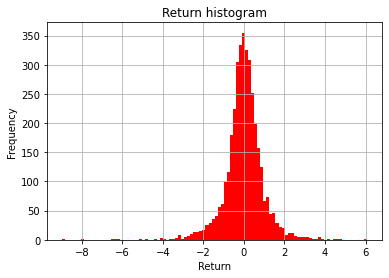

In [14]:
# Plot the histogram
data['Returns'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.title('Return histogram')
plt.show()

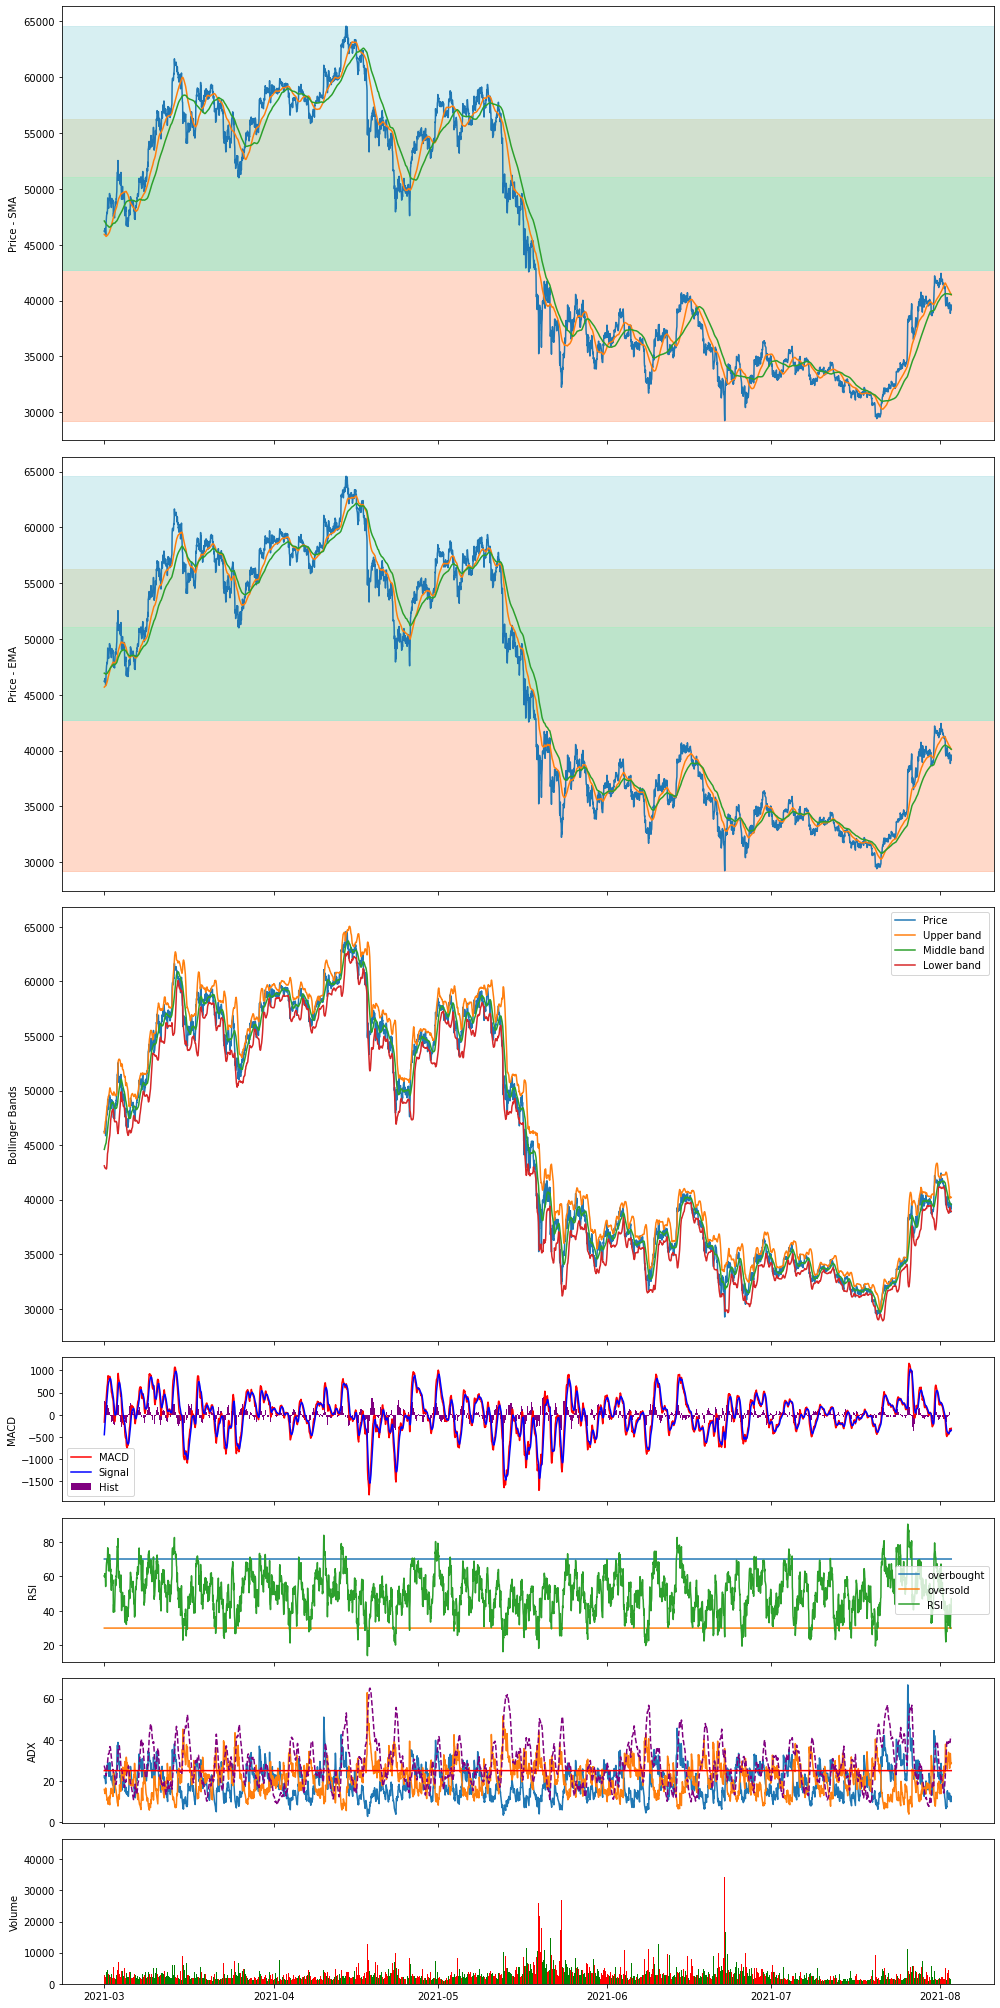

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.legend()
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.bar(data.index, data['MACDHist'], label='Hist', color="purple", width = timedelta(hours=1))
ax4.plot(data.index, data['MACDSignal'], label='Signal', color='blue')
ax4.legend()
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['RSI'], label='RSI')
ax5.legend()
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
# make bar plots and color differently depending on up/down for the day
pos = data['OpenPrice'] - data['ClosePrice'] < 0
neg = data['OpenPrice'] - data['ClosePrice'] > 0
ax7.bar(data.index[pos], data[pos]['Volume'], color='green', width = timedelta(hours=1))
ax7.bar(data.index[neg], data[neg]['Volume'], color='red', width = timedelta(hours=1))

#ax7.bar(data.index, data['Volume'] / 1000000, width = timedelta(hours=4))
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [16]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

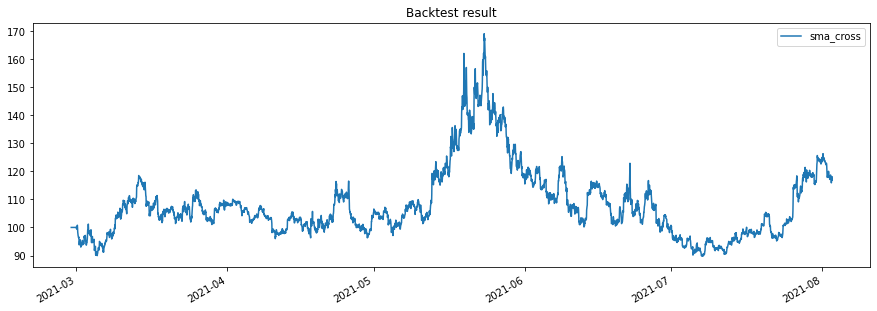

In [17]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_sma_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

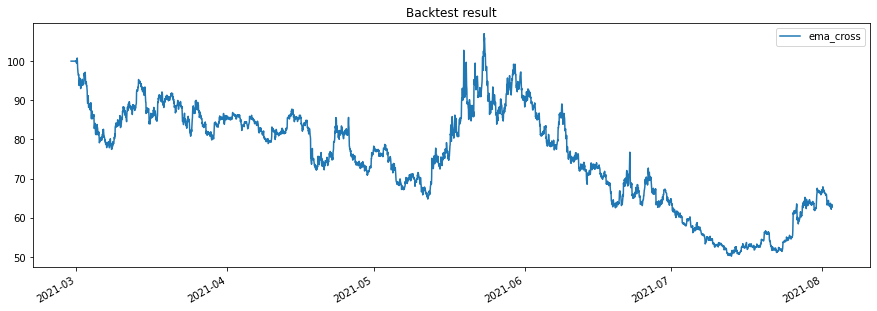

In [18]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_ema_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

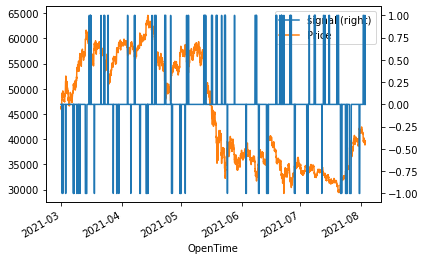

In [19]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

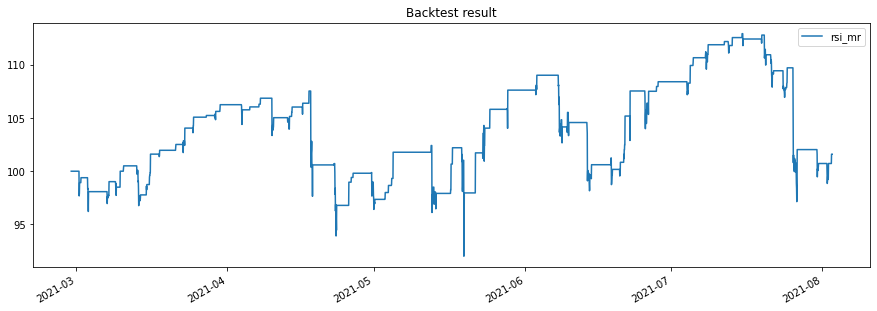

In [20]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

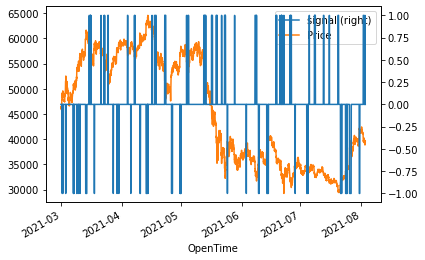

In [21]:
from backtest_utils import get_rsi_adx_signal, signal_strategy

signal = get_rsi_adx_signal(data[['RSI']].copy(), data[['ADX']])

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

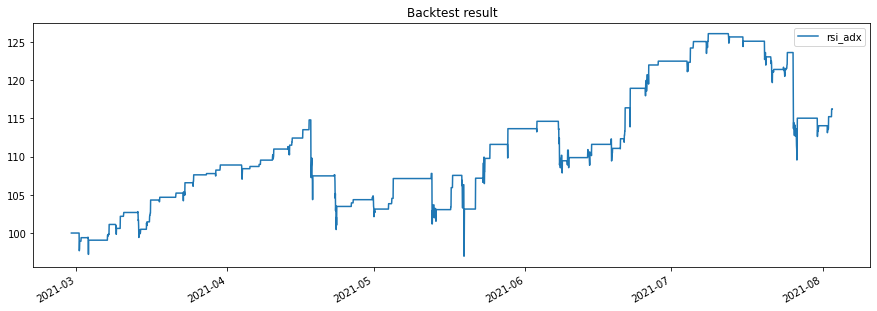

In [22]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

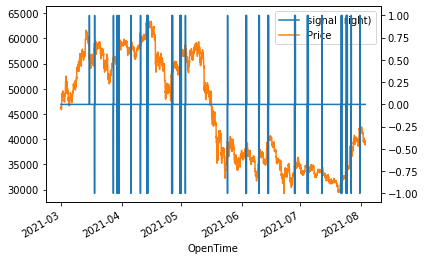

In [23]:
from backtest_utils import get_rsi_plus_signal, signal_strategy

signal = get_rsi_plus_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

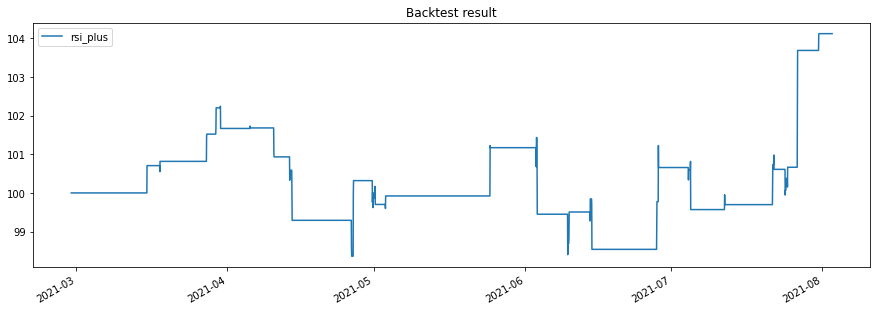

In [24]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

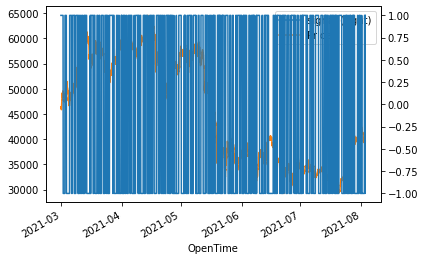

In [25]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['MACDSignal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

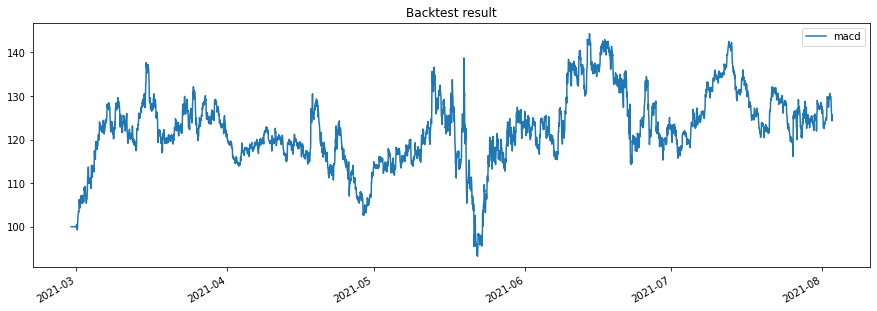

In [26]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

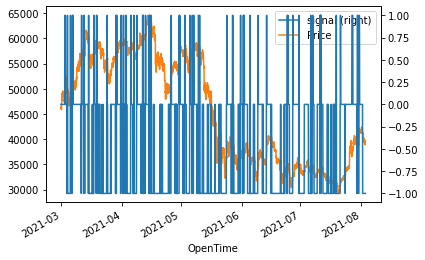

In [27]:
from backtest_utils import get_sma_macd_signal, signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

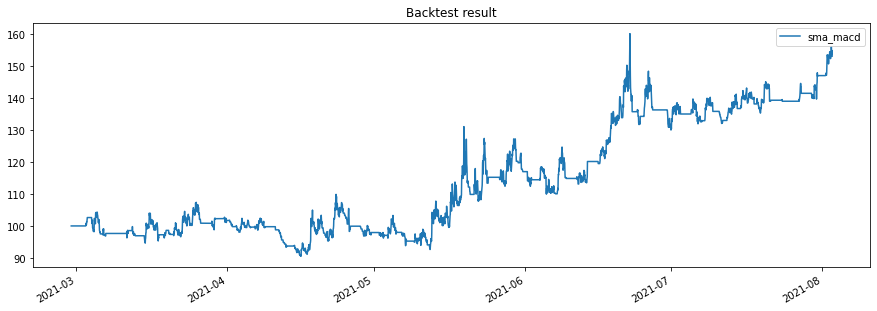

In [28]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

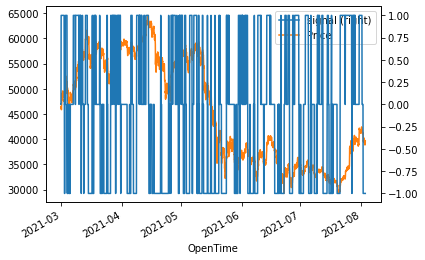

In [29]:
from backtest_utils import get_adx_macd_signal, signal_strategy

signal = get_adx_macd_signal(data[['MACD']].copy(), data[['DI+']].copy(), data[['DI-']].copy(), data[['ADX']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

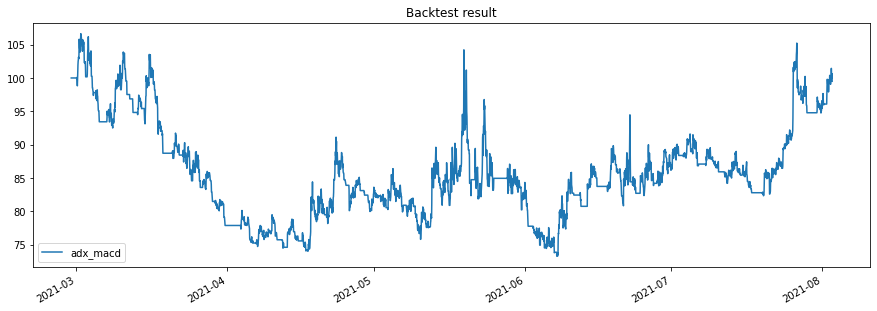

In [30]:
bt_adx_macd = signal_strategy(price_data.copy(), signal, 'adx_macd')

bt_result = bt.run(bt_adx_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [31]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma10 = signal_above_strategy(price_data.copy(), data[['SMA10']].copy(), name='SMA10')
bt_sma20 = signal_above_strategy(price_data.copy(), data[['SMA20']].copy(), name='SMA20')
bt_sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

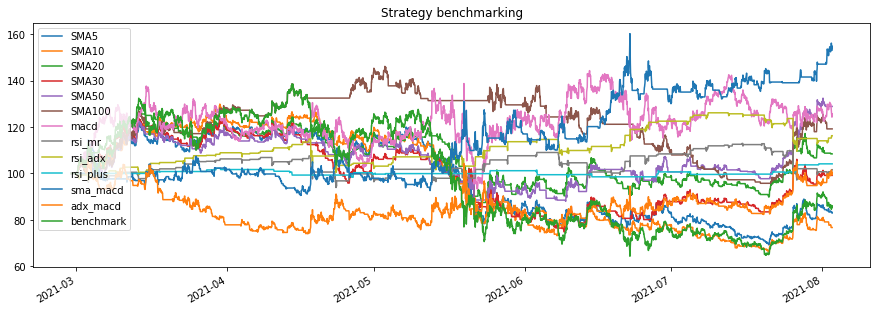

In [32]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5,bt_sma10, bt_sma20, bt_sma30, bt_sma50, bt_sma100, bt_macd, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_sma_macd, bt_adx_macd, bt_benchmark)
#bt_results = bt.run(bt_rsi, bt_sma50, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [33]:
bt_results.display()

Stat                 SMA5        SMA10       SMA20       SMA30       SMA50       SMA100      macd        rsi_mr      rsi_adx     rsi_plus    sma_macd    adx_macd    benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28  2021-02-28
End                  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03  2021-08-03
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -17.07%     -23.29%     8.41%       -0.84%      28.86%      19.18%      25.61%      1.60%       16.25% 

In [34]:
# Obtain all backtest stats
resInfo = bt_results.stats
print(resInfo.loc['total_return'].sort_values(ascending=False))

best_strategy = ''
best_total_return = -1
for strategy, total_return in zip(resInfo.loc['total_return'].index, resInfo.loc['total_return'].values):
    if total_return > best_total_return:
        best_total_return = total_return
        best_strategy = strategy

bt_best = bt_results.backtests[best_strategy]
print('Best Strategy: ' + best_strategy)

sma_macd     0.531569
SMA50        0.288558
macd         0.256081
SMA100       0.191797
rsi_adx      0.162538
SMA20        0.084146
rsi_plus     0.041244
rsi_mr       0.016004
adx_macd     -0.00501
SMA30       -0.008411
benchmark   -0.139249
SMA5        -0.170726
SMA10       -0.232882
Name: total_return, dtype: object
Best Strategy: sma_macd


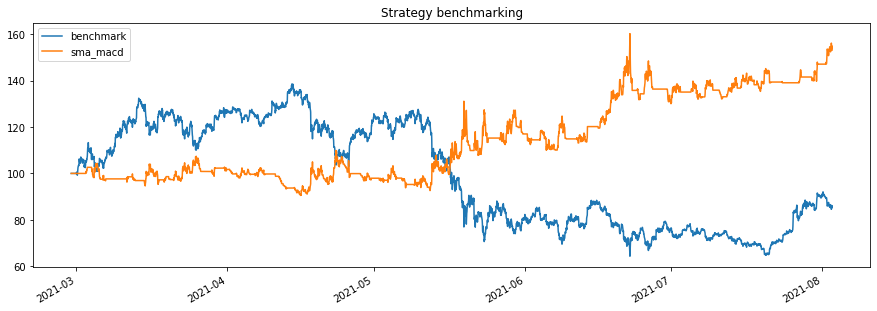

In [35]:
bt_results_best = bt.run(bt_benchmark, bt_best)
bt_results_best.plot(title='Strategy benchmarking')
plt.show()

In [36]:
bt_results_best.get_transactions(strategy_name=best_strategy)

,,price,quantity
Date,Security,,
2021-03-02 23:00:00,value,48440.65,20.0
2021-03-03 07:00:00,value,49752.97,-20.0
2021-03-04 04:00:00,value,49065.33,-21.0
2021-03-04 05:00:00,value,49661.35,21.0
2021-03-04 06:00:00,value,49393.07,-21.0
...,...,...,...
2021-08-02 12:00:00,value,39271.73,-2.0
2021-08-02 13:00:00,value,39581.54,1.0
2021-08-02 20:00:00,value,38851.84,-2.0


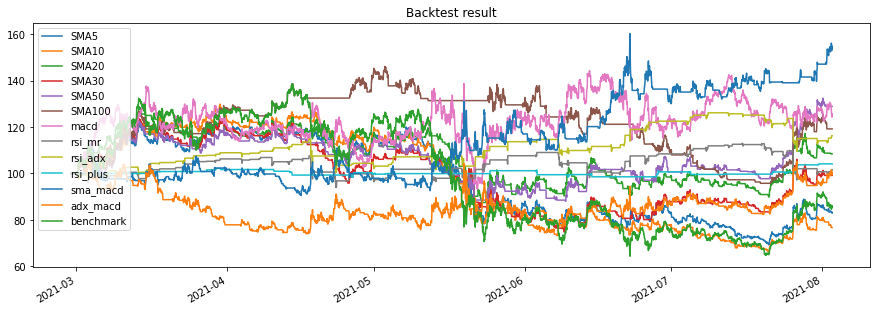

          SMA5    SMA10   SMA20   SMA30   SMA50   SMA100    macd rsi_mr  \
mtd     -2.75%   -3.80%  -0.87%   0.07%  -0.42%   -2.82%  -1.52%  0.87%   
3m     -26.80%  -32.93%  -2.85%  -6.78%  16.70%  -16.20%  10.04%  3.68%   
6m        nan%     nan%    nan%    nan%    nan%     nan%    nan%   nan%   
ytd    -17.07%  -23.29%   8.41%  -0.84%  28.86%   19.18%  25.61%  1.60%   
1y        nan%     nan%    nan%    nan%    nan%     nan%    nan%   nan%   
3y        nan%     nan%    nan%    nan%    nan%     nan%    nan%   nan%   
5y        nan%     nan%    nan%    nan%    nan%     nan%    nan%   nan%   
10y       nan%     nan%    nan%    nan%    nan%     nan%    nan%   nan%   
incep  -35.49%  -46.24%  20.82%  -1.96%  81.05%   50.80%  70.54%  3.79%   

      rsi_adx rsi_plus sma_macd adx_macd benchmark  
mtd     1.93%    0.00%    4.14%    4.27%    -4.38%  
3m     12.72%    4.21%   58.93%   23.70%   -30.02%  
6m       nan%     nan%     nan%     nan%      nan%  
ytd    16.25%    4.12%   53.16%   -0.

In [37]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)